In [7]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import copy

from tic_env import TictactoeEnv, OptimalPlayer

In [8]:
env = TictactoeEnv()

In [9]:
from collections import defaultdict
from random import randint
from random import random
    
def valid_move(grid, move):
    return grid[move] == 0

def agrmax(array):
    i_max = 0
    for i, elem in enumerate(array):
        if elem>array[i_max]:
            i_max = i
    return i_max

def grid_repr(grid):
    between_0_2 = grid.reshape((9))+1
    power_of_3 = 3**np.arange(9)
    return (between_0_2*power_of_3).sum()


class QLearning():
    
    def __init__(self, alpha=0.05, gamma=0.99, epsilon=0.1):
        self.q_values = defaultdict(lambda : 0)
        self.last_grid = None
        self.last_action = None

        self.alpha=alpha
        self.gamma=gamma
        self.epsilon=epsilon
        
        
    def act(self, grid):
        move = self._act_random(grid) if random()<self.epsilon else self._act_optimal(grid)
        self._update_qvalue(grid, move)
        
       
        return move
    
    
    def _act_optimal(self, grid):
        actions = [(x,y) for x in range(3) for y in range(3) if valid_move(grid, (x,y))]
        actions_values = list([self.q_value(grid, a) for a in actions])
        
        move = actions[agrmax(actions_values)]
        return move
        
        
    def _act_random(self, grid):
        actions = [(x,y) for x in range(3) for y in range(3) if valid_move(grid, (x,y))]
        move = actions[randint(0,len(actions)-1)]
        return move
    
    def q_value(self, grid, move):
        return self.q_values[(grid_repr(grid),move)]
    def change_qvalue(self, grid, move, value):
        self.q_values[(grid_repr(grid),move)] = value
    
    
    def update_qvalue_end(self, reward=0):
        if self.last_grid is not None and self.last_action is not None:
            state_action = (self.last_grid,self.last_action)
            estimated_q = self.q_value(*state_action)
            delta_q = reward  - estimated_q
            self.change_qvalue(*state_action, estimated_q+self.alpha*delta_q)
          
        
     
        self.last_grid = None
        self.last_action = None
          
    
    def _update_qvalue(self,grid, move, reward=0):
        if self.last_grid is not None and self.last_action is not None:
            action = self._act_optimal(grid)
            state_action = (self.last_grid,self.last_action)
            estimated_q = self.q_value(*state_action)
            delta_q = reward + self.gamma*self.q_value(grid,action) - estimated_q
            self.change_qvalue(*state_action, estimated_q+self.alpha*delta_q)
        
            
        self.last_grid = grid
        self.last_action = move
        
    def update_epsilon(self, new_epsilon):
        self.epsilon = new_epsilon 

In [15]:
def compute_M(q_player, epsilon, n_games = 100):
    env = TictactoeEnv()
    Turns = np.array(['X','O'])
    q_player.update_epsilon(new_epsilon = 0)
    n_wins = 0
    n_loss = 0
    
    for i in range(n_games):
        grid, _, __ = env.observe()
        
        #QPlayer plays first for the first 250 games
        if i < n_games/2 :
            player_opt = OptimalPlayer(epsilon=epsilon, player=Turns[1])
        else :
             player_opt = OptimalPlayer(epsilon=epsilon, player=Turns[0])
        
        for j in range(9):
            if env.current_player == player_opt.player:
                move = player_opt.act(grid)
            else:
                move = q_player.act(grid)

            grid, end, winner = env.step(move, print_grid=False)

            if end:
                if i < n_games/2 :
                    if winner == 'X':
                        n_wins += 1
                    else :
                        n_loss += 1
                        
                else:
                    if winner == 'X':
                        n_loss += 1
                    else:
                        n_wins += 1
                        
                env.reset()
                break
                
    return (n_wins-n_loss)/n_games

In [63]:
def play_against_self_strategy(epsilon, n_games = 20000, average_length = 250.0):
    env = TictactoeEnv()
    Turns = np.array(['X','O'])
    q_player = QLearning(epsilon = epsilon)
    q_copy =  QLearning(epsilon = epsilon)
    q_copy.q_values = q_player.q_values
  
    
   
    M_opts = [] #list that stores the M_opt for each 'average length' games
    M_rands = [] #list that stores the M_opt for each 'average length' games
    
    for i in range(n_games):
        grid, _, __ = env.observe()
      
       
       
        q_copy_turn = Turns[np.mod(i,2)] #Switching who starts at each iteration between q_copy and q_player
    
        for j in range(9):
            
            if env.current_player == q_copy_turn:
                move = q_copy.act(grid)
            else:
                move = q_player.act(grid)
            
            grid, end, winner = env.step(move, print_grid=False)
            
 
            
            if end:
                    
                q_player_reward = env.reward(player=Turns[np.mod(i+1,2)])
                q_copy_reward = env.reward(player=Turns[np.mod(i,2)])
              
                
                if np.mod(i+1, average_length) == 0:
                    print(i)
                    
                    #Computing M_Opt
                    M_opts.append(compute_M(q_player, 0.0))
                    
                    #Computing M_rand
                    M_rands.append(compute_M(q_player, 1.0))
                    
                q_player.update_qvalue_end(reward=q_player_reward)
                q_copy.update_qvalue_end(reward=q_copy_reward)

                env.reset()
                break
                
    return np.array(M_opts), np.array(M_rands)

499
999
1499
1999
2499
2999
3499
3999
4499
4999
5499
5999
6499
6999
7499
7999
8499
8999
9499
9999
10499
10999
11499
11999
12499
12999
13499
13999
14499
14999
15499
15999
16499
16999
17499
17999
18499
18999
19499
19999


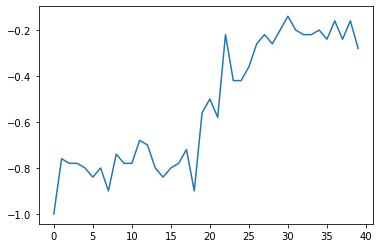

In [64]:
##two players sharing weights
m_opts, m_rands = play_against_self_strategy(0.5, n_games = 20000, average_length = 500.0)
plt.plot(m_opts)

499
999
1499
1999
2499
2999
3499
3999
4499
4999
5499
5999
6499
6999
7499
7999
8499
8999
9499
9999
10499
10999
11499
11999
12499
12999
13499
13999
14499
14999
15499
15999
16499
16999
17499
17999
18499
18999
19499
19999


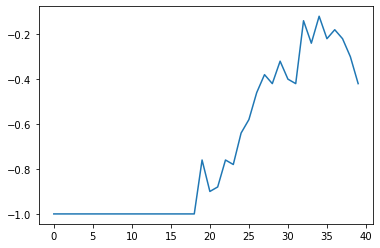

In [62]:
#two player not sharing weights
m_opts, m_rands = play_against_self_strategy(0.1, n_games = 20000, average_length = 500.0)
plt.plot(m_opts)

In [52]:
env = TictactoeEnv()
Turns = np.array(['X','O'])
q_player = QLearning(epsilon = 0.1)
q_copy = copy.deepcopy(q_player)

In [18]:
grid, _, __ = env.observe()
move = q_player.act(grid)
grid, end, winner = env.step(move, print_grid=False)

In [19]:
env.render()

|X - -|
|- - -|
|- - -|



In [20]:
q_player.last_grid

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [22]:
move = q_copy.act(grid)
grid, end, winner = env.step(move, print_grid=False)

In [23]:
env.render()

|X O -|
|- - -|
|- - -|



In [27]:
q_copy.last_action

(0, 1)